# PERM polymer simulation
This program simulates a population of polymers up to a certain length according to the Rosenbluth-Rosenbluth (RR) algorithm or the Prune-Enriched Rosenbluth Method (PERM). From these simulations the end to end distance of the polymers is calculated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

## Adding a bead to the polymer
Place the new bead at one of the angles $\theta_j$ around the last bead of the polymer.

In [2]:
def addBead(pos, L):
    # Calculate the possible positions for the new bead of the polymer. 
    # Then randomly choose one of the positions with a certain probability according to their weight.
    
    # Ntheta random angles for the possible position of the new bead
    angle = 2*np.pi * np.random.rand() + np.linspace(0, 2*np.pi, Ntheta)
    
    # distance between beads for the x and y direction
    dx = pos[L-2, 0] - pos[L-1, 0] 
    dy = pos[L-2, 1] - pos[L-1, 1]
    
    # possible positions of the new bead
    xNewBead = dx*np.cos(angle) - dy*np.sin(angle)
    yNewBead = dy*np.cos(angle) + dx*np.sin(angle)
    
    possibleBeadPos = np.column_stack((xNewBead + pos[L-1, 0], yNewBead + pos[L-1, 1]))
    
    # Calculate Weights
    weight, totalWeight = calculateWeights(possibleBeadPos, pos, L)
    
    randomNumber = np.random.rand() # Create random number to choose the new position of the bead
    index_theta = np.digitize(randomNumber * totalWeight, np.cumsum(weight))
    
    # When the weights are zero the angle is chosen at random
    if index_theta == Ntheta:
        index_theta = np.random.randint(0, 5)
    
    posNewBead = possibleBeadPos[index_theta]
    weightchoosen = weight[index_theta]
    
    return posNewBead, totalWeight

## Weight calculation
The weights $w_n^j = \mathrm{e}^{-E(\theta_j)/k_B T}$ are calculated according to the energy of the Lennard-Jones potential:
$U_{LJ}(r) = 4\epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^{6} \right]$


In [3]:
def calculateWeights(possibleBeadPos, pos, L):
    # Calculate the weights of the possibleBeadPos
    
    # Constants in the Lennard-Jones potential
    eps = 0.25
    sig = 0.8
    sig6 = sig**6
    sig12 = sig**12
    
    E = np.zeros(len(possibleBeadPos))
    
    for n in range(len(possibleBeadPos)):
        # Distance between the new bead and the existing beads
        dx = possibleBeadPos[n, 0] - pos[0:L, 0]
        dy = possibleBeadPos[n, 1] - pos[0:L, 1]
        
        dr2 = 1/(dx*dx + dy*dy)
        
        E[n] = 4*eps*np.sum(sig12*dr2**6 - sig6*dr2**3) # Energy of the polymer according to the Lennard-Jones potential
    
    # Weights corresponding to the new bead positions.
    weight = np.exp(-E/T)
    totalWeight = np.sum(weight)
    
    return weight, totalWeight

## The RR and PERM algorithm using a recursive structure

In [4]:
def growPolymer(pos, L, polWeight, PERM):
    # Grow a polymere up to a length of Nbeads using a recursive structure.
    
    pos[L], totalWeight = addBead(pos, L) # Add a bead to the end of the polymer
    
    # The weight of the polymer is calculated and stored in an array.
    polWeight *= totalWeight/(0.75*Ntheta)
    polymerWeight[count[L], L] = polWeight
    
    # Calculate the end to end distance
    end2EndDistance[count[L], L] = np.sum((pos[0] - pos[L])**2)
    
    count[L] += 1 # Count the number of polymers at bead length L
    
    if (PERM == False and L < Nbeads-1): # Rosenbluth method
        if totalWeight == 0: # If the weight is zero, restart growing this polymer
            count[2:L+1] -= 1
            n[0] -= 1
            
        else:
            growPolymer(pos, L+1, polWeight, PERM)
    
    
    if (PERM and L < Nbeads-1): # PERM method
        if (L < 4 or count[L+1] > Npolymers_max-(Npolymers-ii+2)):
            growPolymer(pos, L+1, polWeight, PERM)
            
        else:
            averageW = np.sum(polymerWeight[:count[L], L])
            weight3 = np.sum(polymerWeight[:count[2], 2])
            
            # Determine the upper and lower limit for pruning and enriching
            upLim = 2*averageW/weight3
            lowLim = 1.2*averageW/weight3
            
            if polWeight > upLim: # Enrich strong polymers
                newWeight = 0.5*polWeight
                growPolymer(pos, L+1, newWeight, PERM)
                growPolymer(pos, L+1, newWeight, PERM)
            
            elif polWeight < lowLim: # Prune weak polymers with 50% chance
                randomNumber = np.random.rand()
                if randomNumber < 0.5:
                    newWeight = 2*polWeight
                    growPolymer(pos, L+1, newWeight, PERM)
            
            else: # Continue growing the polymer without pruning or enriching
                growPolymer(pos, L+1, polWeight, PERM)
                

## Parameters and simulation

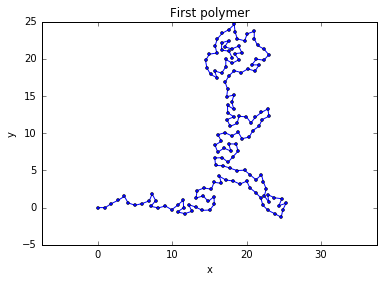

In [5]:
Npolymers = 1000 # Number of polymers, i.e., polymer population
Nbeads = 150 #Number of beads, i.e., polymer length
Ntheta = 6 # Number of angles of the possible new bead positions
T = 1 # Temperature of the system

PERM = True # If PERM = True: use the PERM method. If PERM = False: use the Rosenbluth method

Npolymers_max = Npolymers * 5

# Create empty arrays
pos = np.zeros((Nbeads, 2))
polymerWeight = np.zeros((Npolymers_max, Nbeads))
count = np.zeros((Nbeads), dtype = int)
end2EndDistance = np.zeros((Npolymers_max, Nbeads))
n = np.zeros(1)

# Initial position vector for the first two beads
pos[0] = [0, 0]
pos[1] = [1, 0]


# Grow the first polymer, this is always done with the Rosenbluth method
while n[0] < 1:
    n[0] += 1
    growPolymer(pos, 2, 1, False)


# Plot the first polymer of the population
plt.figure()
plt.plot(pos[:, 0], pos[:, 1], 'o-', ms=3)
plt.title('First polymer')
plt.xlabel('x')
plt.ylabel('y')
plt.tick_params(axis='both', pad=5)
plt.axis('equal')


if PERM:
    for ii in range(1, Npolymers-1):
        growPolymer(pos, 2, 1, PERM)
else:
    while n[0] < Npolymers-1:
        n[0] += 1
        growPolymer(pos, 2, 1, PERM)
        

## Plot the results and fit the data
The weighted average of the end to end distance of the polymer is fitted according to $a(N-1)^{1.5}$ and $a(N-1)^{2\nu}$

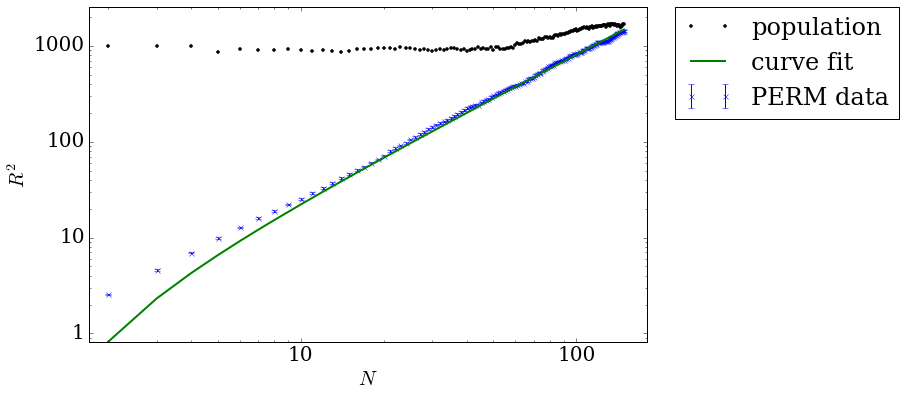

Curve fit function: R^2 = a*(N-1)^1.5
0.8193 *(N-1)^1.5
a = 0.8193 ± 0.0024






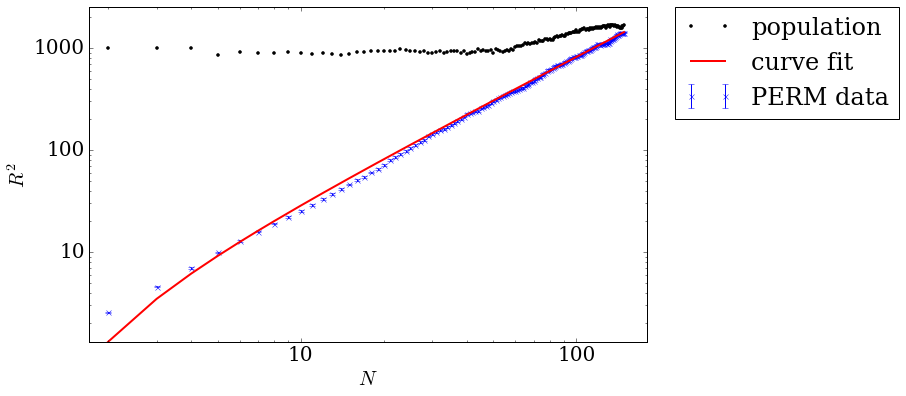

Curve fit function2: R^2 = a*(N-1)^(2v)
1.3168 *(N-1)^(2* 0.7 )
a = 1.3168 ± 0.0474
v = 0.7 ± 0.0038


In [6]:
font = {'family' : 'serif',
        'size'   : 20}
plt.rc('font', **font)


def functionFit(N, a):
    return a*(N-1)**1.5

def functionFit2(N, a, v):
    return a*(N-1)**(2*v)

# Calculate the weighted average of the end to end distance
end2EndDistance_avg = np.average(end2EndDistance[:, 2:], weights=polymerWeight[:, 2:], axis=0)
end2EndDistance_var = np.average(end2EndDistance[:, 2:]**2, weights=polymerWeight[:, 2:], axis=0) - end2EndDistance_avg**2
end2EndDistance_error = np.sqrt(end2EndDistance_var/count[2:])

N = np.arange(2, Nbeads)

popt, pcov = curve_fit(functionFit, N, end2EndDistance_avg)
perr = np.sqrt(np.diag(pcov))
fit = functionFit(N, *popt)

popt2, pcov2 = curve_fit(functionFit2, N, end2EndDistance_avg)
perr2 = np.sqrt(np.diag(pcov2))
fit2 = functionFit2(N, *popt2)


if PERM:
    dataLabel = 'PERM data'
else:
    dataLabel = 'RR data'

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plt.plot(N, count[2:]+1, 'ko', ms=3, label='population')
plt.errorbar(N, end2EndDistance_avg, end2EndDistance_error, fmt='x', color='b', ms=5, label=dataLabel)
plt.plot(N, fit, 'g', lw=2, label='curve fit')
plt.xlabel('$N$')
plt.ylabel('$R^2$')
plt.xscale('log')
plt.yscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylim([0, 1.5*max(np.amax(count[2:]), np.amax(end2EndDistance_avg))])
plt.xlim(1.7, 1.2*Nbeads)
plt.ylim(0, 1.5*max(np.amax(count[2:]), np.amax(end2EndDistance_avg)))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

print('Curve fit function: R^2 = a*(N-1)^1.5')
print(round(popt[0], 4), '*(N-1)^1.5')
print(u'a =', round(popt[0], 4), '\u00B1', round(perr[0], 4))
print('\n\n\n')




fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plt.plot(N, count[2:]+1, 'ko', ms=3, label='population')
plt.errorbar(N, end2EndDistance_avg, end2EndDistance_error, fmt='x', color='b', ms=5, label=dataLabel)
plt.plot(N, fit2, 'r', lw=2, label='curve fit')
plt.xlabel('$N$')
plt.ylabel('$R^2$')
plt.xlim(1.7, 1.2*Nbeads)
plt.xscale('log')
plt.yscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())
plt.ylim(0, 1.5*max(np.amax(count[2:]), np.amax(end2EndDistance_avg)))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

print('Curve fit function2: R^2 = a*(N-1)^(2v)')
print(round(popt2[0], 4), '*(N-1)^(2*', round(popt2[1], 4), ')')
print(u'a =', round(popt2[0], 4), '\u00B1', round(perr2[0], 4))
print(u'v =', round(popt2[1], 4), '\u00B1', round(perr2[1], 4))


## Plot the polymer count

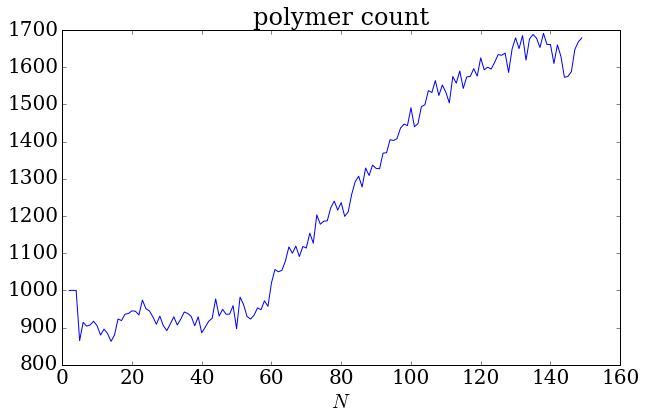

In [7]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.arange(2, Nbeads), count[2:]+1)
plt.title('polymer count')
plt.xlabel('$N$')

plt.show()